In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys
import torch.nn.functional as F


# Build an Autoencoder for a human face dataset

We will use a dataset containig images of people and train an autoencoder on it.

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [ ]:

# Unzip the lfw.zip file in the sample_data directory
!unzip /content/lfw.zip -d /content/lfw

# Now, set the path variable to the directory containing the unzipped LFW images
path = '/content/lfw/lfw'

Streaming output truncated to the last 5000 lines.
  inflating: /content/lfw/lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0021.jpg  
  inflating: /content/lfw/__MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0021.jpg  
  inflating: /content/lfw/lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0020.jpg  
  inflating: /content/lfw/__MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0020.jpg  
  inflating: /content/lfw/lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0008.jpg  
  inflating: /content/lfw/__MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0008.jpg  
  inflating: /content/lfw/lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0022.jpg  
  inflating: /content/lfw/__MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0022.jpg  
  inflating: /content/lfw/lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0023.jpg  
  inflating: /content/lfw/__MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0023.jpg  
  inflating: /content/lfw/lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_

In [ ]:
transform    = transforms.Compose([transforms.ToTensor()])
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)


This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [ ]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")


MPS device not found.


torch.Size([250, 250, 3])


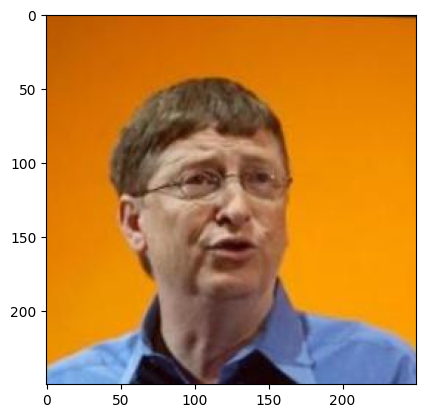

In [ ]:
# Assuming 'image_folder' is your directory containing the images
image_folder = '/content/lfw/lfw/Steven_Craig/'

# Filter out files starting with '._'
valid_image_files = [f for f in os.listdir(image_folder) if not f.startswith('._') and f.lower().endswith(('.png', '.jpg', '.jpeg'))]


for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

## Step 2
Each datapoint is an image. Get a sample of the data and print its dimensions and explain what each dimension means.

In [ ]:
# Assuming 'dataloader' is your DataLoader object
images, labels = next(iter(dataloader))
sample_image = images[0]
print(sample_image.shape)

torch.Size([3, 250, 250])


A typical image tensor from a DataLoader in PyTorch will have three dimensions, represented as [C, H, W]:

C (Channels): The number of color channels in the image. For standard RGB (Red, Green, Blue) images, this will be 3. For grayscale images, this will be 1. The channels represent the intensity of each color in the pixel.

H (Height): The height of the image in pixels. This represents how many pixels there are from the top to the bottom of the image.

W (Width): The width of the image in pixels. This represents how many pixels there are from one side of the image to the other.

The output is in the format [C, H, W] as explained above.

# Step 3

Create a new pytorch model calss for your autoencoder. You can use Conv2d, MaxPool2d, BatchNorm2d, ConvTranspose2d and Linear Layers as as well as activation functions. Optionally, you can use UpSample, AveragePool2d and Interpolate2d as well.

**Create seperate functions for the encoder and decoder.**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AE(nn.Module):

    def __init__(self):
        super(AE, self).__init__()

        # Modified encoder layers
        self.encoder_conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=4, stride=1, padding=1)
        self.encoder_bn1 = nn.BatchNorm2d(16)
        self.encoder_pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.encoder_conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4, stride=1, padding=1)
        self.encoder_bn2 = nn.BatchNorm2d(32)
        self.encoder_pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Additional encoder layer for more depth
        self.encoder_conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=1, padding=1)
        self.encoder_bn3 = nn.BatchNorm2d(64)
        self.encoder_pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Modified decoder layers
        self.decoder_conv1 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=4, padding=1)
        self.decoder_bn1 = nn.BatchNorm2d(32)
        self.decoder_upsample1 = nn.Upsample(scale_factor=2, mode='nearest')  # Replaced with nn.Upsample

        self.decoder_conv2 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=4, padding=1)
        self.decoder_bn2 = nn.BatchNorm2d(16)
        self.decoder_upsample2 = nn.Upsample(scale_factor=2, mode='nearest')  # Replaced with nn.Upsample

        self.decoder_conv3 = nn.Conv2d(in_channels=16, out_channels=3, kernel_size=4, padding=1)
        self.decoder_bn3 = nn.BatchNorm2d(3)
        self.decoder_upsample3 = nn.Upsample(scale_factor=2, mode='nearest')  # Additional upsampling layer

    def encoder(self, x):
        x = F.relu(self.encoder_bn1(self.encoder_conv1(x)))
        x = self.encoder_pool1(x)
        x = F.relu(self.encoder_bn2(self.encoder_conv2(x)))
        x = self.encoder_pool2(x)
        x = F.relu(self.encoder_bn3(self.encoder_conv3(x)))  # New layer
        x = self.encoder_pool3(x)  # New layer
        return x

    def decoder(self, x):
        x = self.decoder_upsample1(x)  # Upsample
        x = F.relu(self.decoder_bn1(self.decoder_conv1(x)))

        x = self.decoder_upsample2(x)  # Upsample
        x = F.relu(self.decoder_bn2(self.decoder_conv2(x)))

        x = self.decoder_upsample3(x)  # Upsample
        x = F.relu(self.decoder_bn3(self.decoder_conv3(x)))

        # Final adjustment to ensure correct output size
        x = F.interpolate(x, size=(250, 250), mode='bilinear', align_corners=False)

        return x

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


## Step 4
Create an instance of the class, pass an image to the model, print the shape of the output of the **encoder** and the **decoder**. Check the dimensions and make sure your forward path is working properly.

In [ ]:
# Create an instance of the AE class
model = AE()

# Create a dummy input image with the correct dimensions
# Adjusted to match the size your model is designed for (250x250)
dummy_input = torch.randn(1, 3, 250, 250)  # Batch size 1, 3 channels, 250x250 pixels

# Pass the dummy image through the model
with torch.no_grad():  # We don't need to track gradients for this
    encoded = model.encoder(dummy_input)
    decoded = model.decoder(encoded)

# Print the shapes of the outputs
print("Shape of encoder output:", encoded.shape)
print("Shape of decoder output:", decoded.shape)


Shape of encoder output: torch.Size([1, 64, 30, 30])
Shape of decoder output: torch.Size([1, 3, 250, 250])


##  Step 5
Print total number of parameters in the model, explain what loss function you should use, create an optimizer for training

In [ ]:
# Assuming 'model' is your AE instance
total_params = sum(p.numel() for p in model.parameters())
print("Total number of parameters: ", total_params)


Total number of parameters:  83945


In [ ]:
# For Adam optimizer
optim = torch.optim.Adam(model.parameters(), lr=0.001)  # lr is the learning rate

# For SGD optimizer
# optim = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


**Loss function to be used:** MSE is one of the most common loss functions for autoencoders when the objective is to minimize the difference between the original and reconstructed images. It works well if the input data is normalized and if the autoencoder is mainly used for tasks like denoising or if the pixel-wise difference is important.

In [ ]:
loss_function = torch.nn.MSELoss()


##  Step 6
Write a training loop and start trainng the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [ ]:
# Assuming you have a DataLoader for your dataset named 'dataloader'
# and you've defined 'model', 'loss_function', and 'optim' as before

num_epochs = 5  # Number of epochs

for epoch in range(num_epochs):
    total_loss = 0.0

    for data in dataloader:
        inputs, _ = data  # Autoencoders typically don't use labels

        # Zero the parameter gradients
        optim.zero_grad()


                      # Assuming 'dataloader' is your DataLoader
        dataiter = iter(dataloader)
        images, labels = next(dataiter)

        # Check the size of the first image
       # print("Size of the first image:", images[0].size())
        # Forward pass

         # Print the size of the input images
       # print("Input size:", inputs.size())
        outputs = model(inputs)
       # print("Output size:", outputs.size())
        loss = loss_function(outputs, inputs)

        # Backward pass and optimize
        loss.backward()
        optim.step()

        total_loss += loss.item()

    # Calculate average loss for the epoch
    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

# Save the model after training
torch.save(model.state_dict(), 'model.pth')


Epoch 1/5, Loss: 0.0157
Epoch 2/5, Loss: 0.0116
Epoch 3/5, Loss: 0.0105
Epoch 4/5, Loss: 0.0098
Epoch 5/5, Loss: 0.0092


If your loss is not decreasing during training, it could indicate several potential issues. Troubleshooting this involves a systematic check of various aspects of your training setup:

**Learning Rate:** It might be too high or too low. Try adjusting it. If it's too high, the model might overshoot the minimum; if it's too low, the model might not be taking large enough steps to reach the minimum or could get stuck in a local minimum.

**Model Capacity:** Ensure that the model has enough capacity to learn from the data. A model that's too simple may not be able to capture the complexity of the data (underfitting).

**Overfitting:** If the loss decreases on the training set but not on a validation set, the model could be overfitting. Add regularization methods like dropout, weight decay, or consider simplifying the model.

**Initialization:** Weights should be properly initialized. Poor initialization can hinder the learning process.

There are several other factors that we can check which include loss function,optimizer etc.


##  Step 7

Take a random image from the dataset and plot it against the reconstructed (encoded + decoded) image.

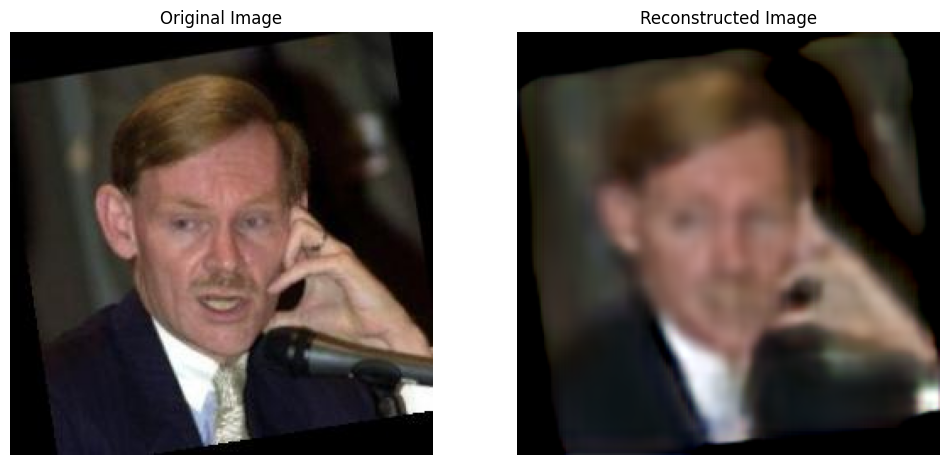

In [ ]:
import torch
import matplotlib.pyplot as plt
import random

# Set the model to evaluation mode
model.eval()

# Load a random image from the dataset
random_index = random.randint(0, len(dataloader.dataset) - 1)
original_image, _ = dataloader.dataset[random_index]

# Add batch dimension and pass the image through the model
input_image = original_image.unsqueeze(0)  # Add batch dimension
with torch.no_grad():
    reconstructed_image = model(input_image)

# Convert the tensors to numpy arrays for plotting
original_image_np = original_image.permute(1, 2, 0).numpy()
reconstructed_image_np = reconstructed_image.squeeze().permute(1, 2, 0).numpy()

# Plot the original and reconstructed images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(original_image_np)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image_np)
plt.title('Reconstructed Image')
plt.axis('off')

plt.show()

##  Step 8

In step 7, add a small normaly distrubuted noise to the latent (hidden) representation of the input image and then decode it again. How is adding noise affecting the decoded image ?

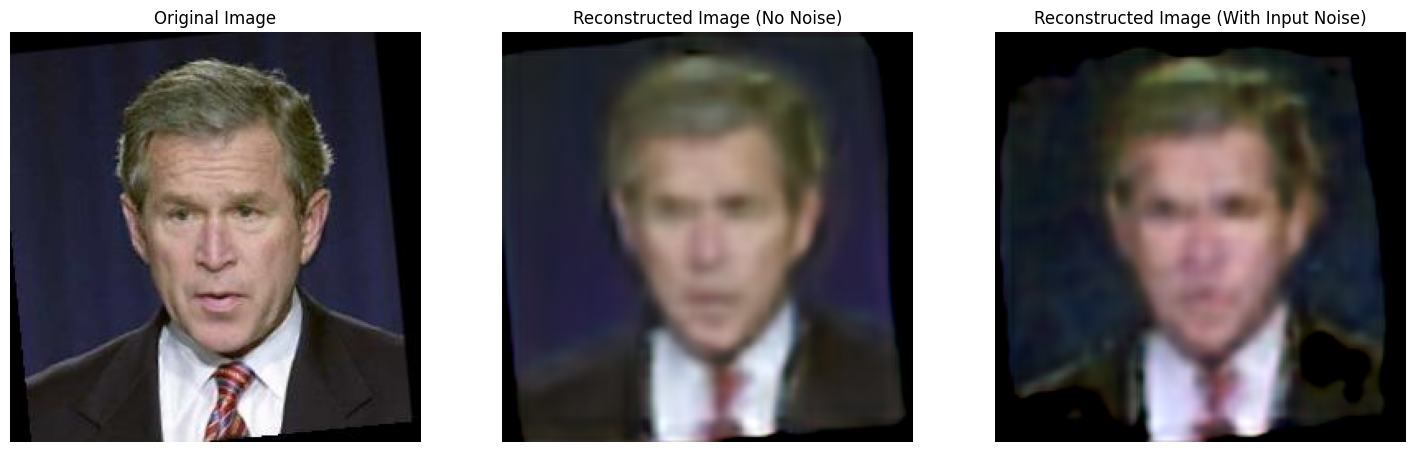

In [ ]:
import matplotlib.pyplot as plt
import random
import torch

# Set the model to evaluation mode
model.eval()

# Load a random image from the dataset
random_index = random.randint(0, len(dataloader.dataset) - 1)
original_image, _ = dataloader.dataset[random_index]
input_image = original_image.unsqueeze(0)  # Add batch dimension

# Forward pass to get the reconstructed image
with torch.no_grad():
    reconstructed_image = model(input_image)

# Add noise to the input image
noise = torch.randn_like(input_image) * 0.1  # Adjust noise level as needed
noisy_input_image = input_image + noise

# Forward pass for the noisy image
with torch.no_grad():
    reconstructed_noisy_image = model(noisy_input_image)

# Convert to numpy arrays for plotting
original_image_np = original_image.permute(1, 2, 0).numpy()
reconstructed_image_np = reconstructed_image.squeeze().permute(1, 2, 0).numpy()
reconstructed_noisy_image_np = reconstructed_noisy_image.squeeze().permute(1, 2, 0).numpy()

# Plotting
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.imshow(original_image_np)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(reconstructed_image_np)
plt.title('Reconstructed Image (No Noise)')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(reconstructed_noisy_image_np)
plt.title('Reconstructed Image (With Input Noise)')
plt.axis('off')

plt.show()


The code introduces synthetic noise to an input image by adding randomly generated values to each pixel. This noise is scaled by a factor of 0.1, which means it's meant to be relatively small compared to the image's original pixel values. The purpose of adding this noise is to simulate a real-world scenario where input data might be corrupted or imperfect. By passing the noisy image through the autoencoder, the code aims to demonstrate the model's ability to reconstruct the original image despite the presence of noise, thus testing the robustness of the model's learned representations. The effectiveness of the noise reduction is then visually assessed by comparing the noisy input with the model's output—a less noisy, reconstructed image.